In [2]:
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed

In [3]:
import utils
import autoregression as ar
import neural_network as nn

In [4]:
temperature = utils.parse_file('data/pcu1/Supply trafo A winding 2W temp.csv', 'temp')
temperatureX = utils.parse_file('data/pcu1/Supply trafo A winding 2U temp.csv', 'tempX')
temperatureY = utils.parse_file('data/pcu1/Supply trafo A winding 2V temp.csv', 'tempY')
auxiliaries = utils.parse_file('data/pcu1/AUX ON from PCU.csv', 'aux_on')
current = utils.parse_file('data/pt1/i1.csv', 'I')

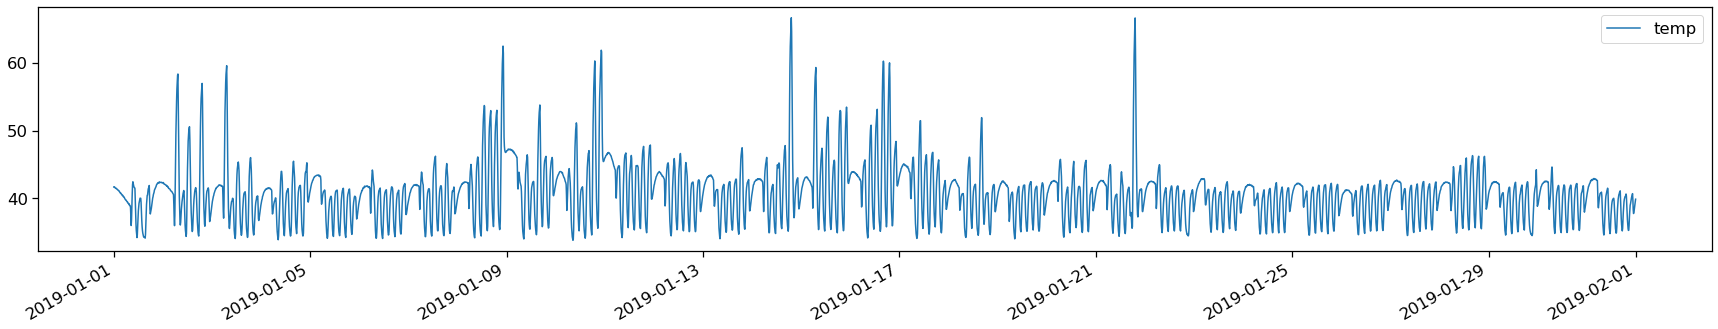

In [184]:
temperature['2019-01-01 00:00:00':'2019-02-01 00:00:00'].plot(figsize=(30,5))
plt.show()

In [328]:
X, y = ar.prep_current_model_dataset(auxiliaries, current, temperature, 9)
X.head(0)

,aux_on,aux_off,I,I2,temp__1,temp__2,temp__3,temp__4,temp__5,temp__6,temp__7,temp__8,temp__9


In [280]:
X, y = ar.prep_current_temp_model_dataset(auxiliaries, current, temperature, temperatureX, temperatureY, 1)
X.head(1)

,aux_on,aux_off,I,I2,tempX,tempY,temp__1
2018-06-04 12:30:00,1.0,0.0,51.0,2601.0,38.276489,40.089264,39.519348


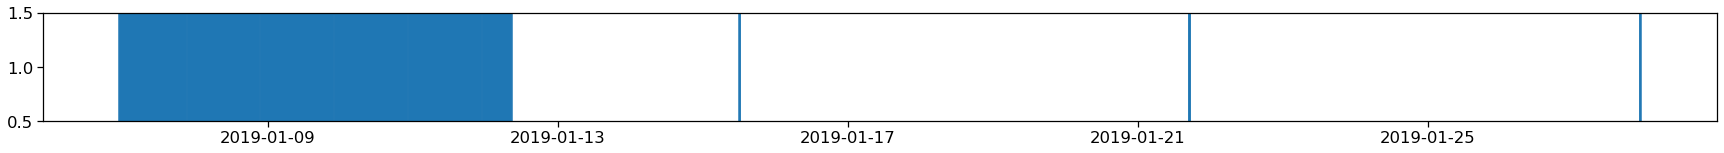

In [213]:
T = utils.sample_gaps(X['2019-01-01 00:00:00':'2019-01-31 00:00:00'])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,2))
#axes.stem(T.index, T['gap'], markerfmt=' ', basefmt=' ')
axes.eventplot(T.index, orientation='horizontal')
axes.set_ylim(.5,1.5)
plt.show()

<AxesSubplot:>

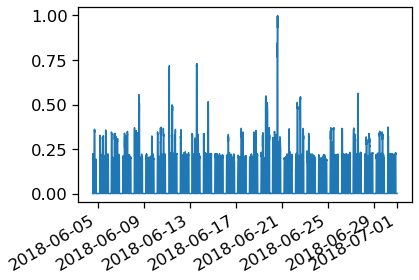

In [277]:
X_train['I2'].plot()

In [371]:
y_pred

,temp
2019-01-13 00:09:00,41.036850
2019-01-13 00:19:00,40.889793
2019-01-13 00:29:00,40.629590
2019-01-13 00:39:00,40.343291
2019-01-13 00:49:00,40.112880
...,...
2019-01-24 23:16:00,39.214029
2019-01-24 23:26:00,39.184094
2019-01-24 23:36:00,39.191418
2019-01-24 23:46:00,39.278090


/home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/olav/Documents/stud/FYS-STK4155/project3/source/autoregression.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeffs.iloc[:,:] = (np.linalg.pinv(X.to_numpy()) @ y.to_numpy()).T


R2=0.861, MSE=2.620e+00


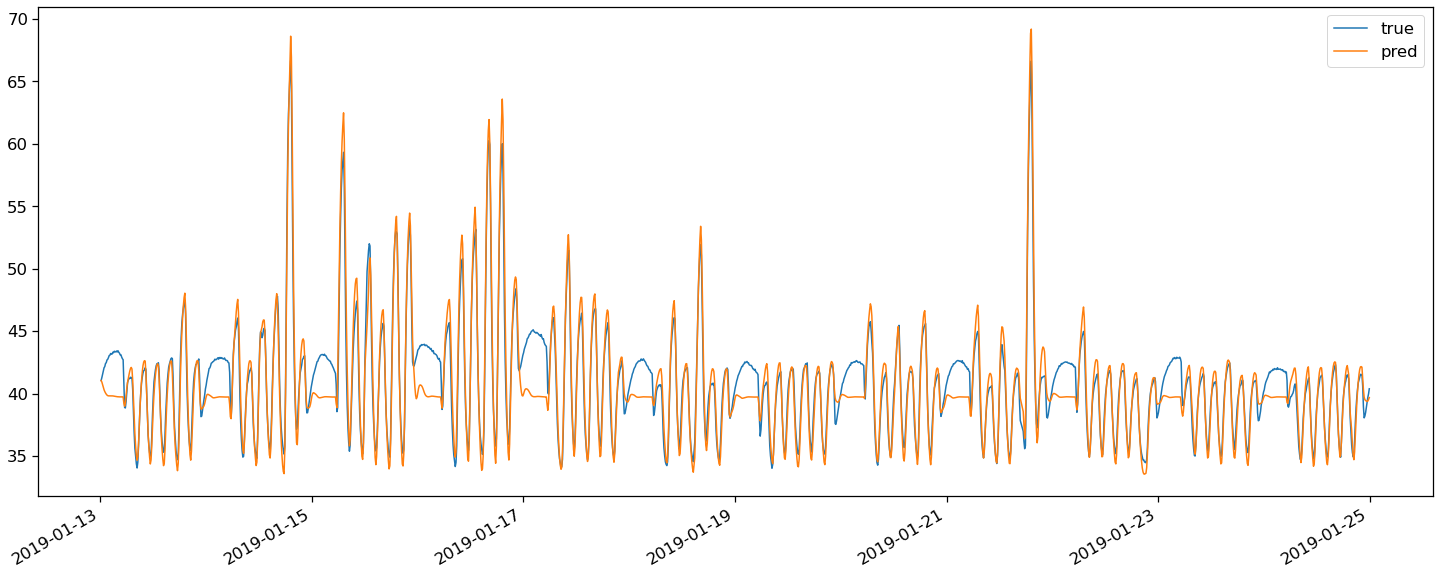

In [374]:
start = None
end = '2018-08-01 00:00:00'
X_train, y_train = X[start:end], y[start:end]

start='2019-01-13 00:00:00'
end='2019-01-25 00:00:00'
X_test, y_test = X[start:end], y[start:end]

#scaler = skl.preprocessing.MinMaxScaler()
#scaler.fit(X_train)
#X_train.iloc[:,:] = scaler.transform(X_train)
#X_test.iloc[:,:] = scaler.transform(X_test)

coeffs = ar.ols(X_train, y_train)

y_pred = ar.evaluate(coeffs, X_test, y_test['temp'][0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax = axes
y_test.plot(ax=ax)
y_pred.plot(ax=ax)


r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

ax.legend(['true', 'pred'])
plt.show()

In [5]:
def reshape(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, batch_size, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,:,0] = y[i:i+batch_size,0]
    return features, targets

def reshape2(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, 1, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,0,0] = y[i+batch_size,0]
    return features, targets

In [6]:
X, y = nn.prep_current_model_dataset(auxiliaries, current, temperature)

In [7]:
start=None
end='2018-08-01 00:00:00'
X_train, y_train = X[start:end].to_numpy(), y[start:end].to_numpy()
n, p = X_train.shape

start='2019-01-13 00:00:00'
end='2019-01-25 00:00:00'
X_test, y_test = X[start:end].to_numpy(), y[start:end].to_numpy()
X_train.shape, X_test.shape

((8166, 3), (1717, 3))

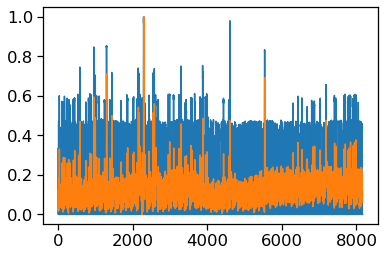

In [8]:
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:,0] = X_train[:,0]
X_test_scaled[:,0] = X_test[:,0]

ymin, ymax = y_train.min(), y_train.max()
scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

scaler.fit(y_train_scaled)
y_train_scaled = scaler.transform(y_train_scaled)
y_test_scaled = scaler.transform(y_test_scaled)

plt.plot(X_train_scaled[:,1])
plt.plot(y_train_scaled[:,0])
plt.show()

In [9]:
sample_size = 24
X_train_reshaped, y_train_reshaped = reshape(X_train_scaled, y_train_scaled, sample_size)
X_test_reshaped, y_test_reshaped = reshape(X_test_scaled, y_test_scaled, sample_size)

In [10]:
model = Sequential([
    LSTM(30, return_sequences=True, input_shape=(sample_size, p), dropout=.0, recurrent_dropout=.2, unroll=True),
    LSTM(18, return_sequences=True, unroll=True),
    Dense(sample_size)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 30)            4080      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 18)            3528      
_________________________________________________________________
dense (Dense)                (None, 24, 24)            456       
Total params: 8,064
Trainable params: 8,064
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs = 5
batch_size = 50
model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=True)

Epoch 1/5
163/163 [==============================] - 12s 75ms/step - loss: 0.0078
Epoch 2/5
163/163 [==============================] - 14s 89ms/step - loss: 0.0038
Epoch 3/5
163/163 [==============================] - 15s 91ms/step - loss: 0.0023
Epoch 4/5
163/163 [==============================] - 16s 95ms/step - loss: 0.0019
Epoch 5/5
163/163 [==============================] - 17s 102ms/step - loss: 0.0017


R2=0.943, MSE=1.079e+00


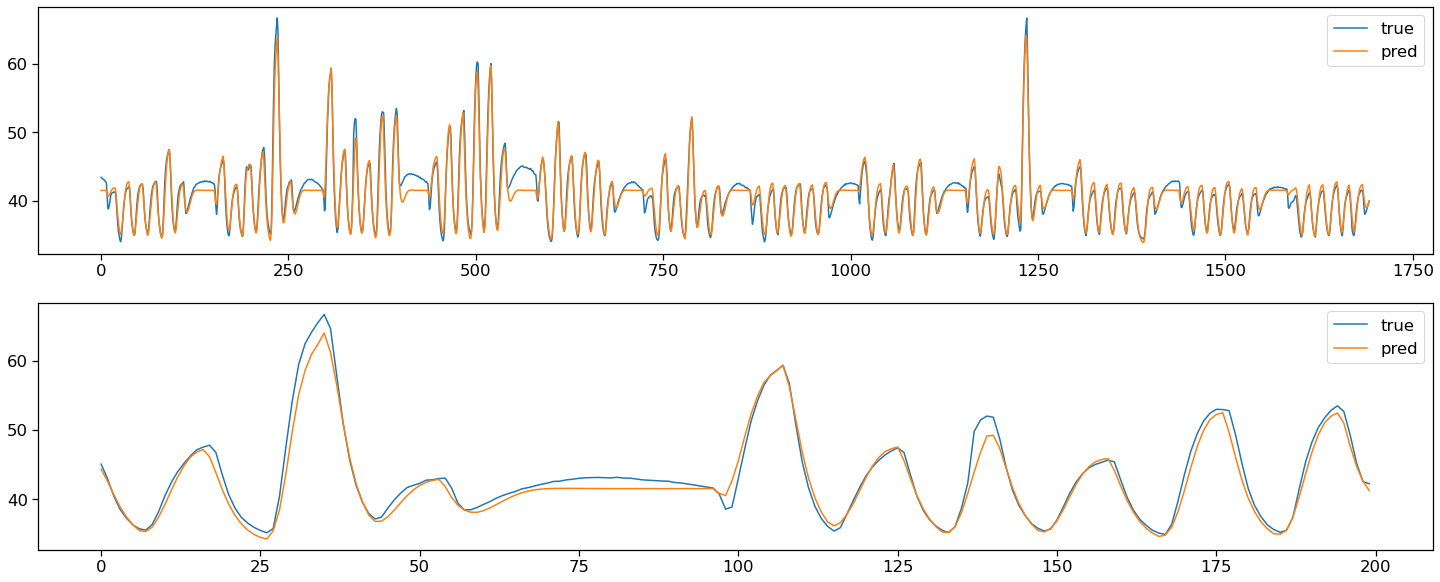

In [12]:
y_pred_raw = model.predict(X_test_reshaped)
y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
y_pred = y_pred*(ymax - ymin) + ymin
shift = 1
y_true = y_test[sample_size-shift:-1*shift if shift else len(y_true)-1]


r2 = skl.metrics.r2_score(y_true, y_pred)
mse = skl.metrics.mean_squared_error(y_true, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))
ax = axes[0]
ax.plot(y_true)
ax.plot(y_pred)
ax.legend(['true', 'pred'])

ax = axes[1]
start, end = 200, 400
ax.plot(y_true[start:end])
ax.plot(y_pred[start:end])
ax.legend(['true', 'pred'])

plt.show()